In [1]:
!pip install pandas matplotlib wordcloud google-generativeai scikit-learn nltk tqdm


In [2]:
import os
import email
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import google.generativeai as genai
from sklearn.ensemble import IsolationForest
from wordcloud import WordCloud, STOPWORDS
import nltk
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define source and destination paths
source_path = "/content/drive/My Drive/EnronDataset/maildir/maildir_backup.zip"
destination_path = "/content/maildir_backup.zip"

# Copy file from Google Drive
!cp "{source_path}" "{destination_path}"

# Check if the file exists after copying
if os.path.exists(destination_path):
    print(" File copied successfully! Ready for extraction.")
else:
    print(" File copy failed. Please check the file path.")


 File copied successfully! Ready for extraction.


In [5]:
!ls -lh /content/maildir_backup.zip


-rw------- 1 root root 684M Feb 20 00:07 /content/maildir_backup.zip


In [6]:
import zipfile

# Define paths
zip_path = "/content/maildir_backup.zip"
extract_path = "/content/maildir"

# Extract ZIP file
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted successfully!")

    # Verify extraction by listing top-level directories
    extracted_folders = os.listdir(extract_path)
    if len(extracted_folders) > 0:
        print(f"📂 Extracted {len(extracted_folders)} folders inside maildir.")
        print("Sample folders:", extracted_folders[:10])  # Show first 10 folders
    else:
        print("⚠️ Extraction completed, but no folders were found!")

except zipfile.BadZipFile:
    print("❌ Error: Corrupt ZIP file. Please re-upload.")
except FileNotFoundError:
    print("❌ Error: ZIP file not found. Ensure it's correctly copied from Google Drive.")


✅ Dataset extracted successfully!
📂 Extracted 1 folders inside maildir.
Sample folders: ['maildir']


In [7]:
!ls -l /content/maildir | head -20


total 4
drwxr-xr-x 152 root root 4096 Feb 20 00:07 maildir


In [8]:
!find /content/maildir -type f | wc -l


517401


In [9]:
import email
import pandas as pd
from tqdm import tqdm

# Function to load emails into a structured DataFrame
def load_enron_emails(dataset_path, max_emails=10000):
    emails = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith("."):  # Ensure we're reading only email files
                try:
                    with open(os.path.join(root, file), "r", encoding="latin-1") as f:
                        content = f.read()
                        e = email.message_from_string(content)
                        emails.append({
                            "Message-ID": e.get("Message-ID"),
                            "Date": e.get("Date"),
                            "From": e.get("From"),
                            "To": e.get("To"),
                            "Subject": e.get("Subject"),
                            "Body": e.get_payload()
                        })
                except Exception:
                    pass
            if len(emails) >= max_emails:  # Limit dataset for performance
                break
    return pd.DataFrame(emails)

# Load dataset (limiting to 10,000 emails for performance)
df = load_enron_emails("/content/maildir", max_emails=10000)

# Fix Date Parsing Issue
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)

# Drop rows with missing data
df = df.dropna()

# Display the cleaned dataset (first 5 rows)
df.head()


<ipython-input-9-c9639a3d3b61>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)


,Message-ID,Date,From,To,Subject,Body
0,<8628846.1075841459361.JavaMail.evans@thyme>,2001-07-10 18:01:51+00:00,karim.punja@enron.com,cooper.richey@enron.com,Financial True ups,"Cooper,\n\n\nHere is the way I think of what d..."
2,<4593540.1075841460714.JavaMail.evans@thyme>,2001-10-16 16:29:03+00:00,sebastien.garcia@enron.com,"sebastien.garcia@enron.com, cooper.richey@enro...",Scraping process Vs Volume Mgmt,\nGround to cover:\n\n- Review of scraping pro...
10,<27876452.1075841460618.JavaMail.evans@thyme>,2002-02-06 17:42:43+00:00,chris.wiebe@enron.com,"chris.wiebe@enron.com, richard.mckeel@enron.co...",IIS Meeting,As per email
17,<30585975.1075841460687.JavaMail.evans@thyme>,2001-10-18 22:27:04+00:00,mark.dupuy@enron.com,"mark.dupuy@enron.com, cooper.richey@enron.com",FW: let's go for drinks after work,"Cooper,\n\nIf you are interested....\n\nCraig\..."
21,<23365740.1075841481399.JavaMail.evans@thyme>,2001-12-04 22:54:11+00:00,clinton.kripki@gfinet.com,cooper.richey@enron.com,GFI AB Power Fax,<<AB Power Fax for 26/11/01>> <<AB Power Fax...


In [10]:
import pandas as pd

# Count of Emails Sent by Each Sender
sender_counts = df["From"].value_counts()

# Count of Emails Received by Each Recipient
df["To"] = df["To"].astype(str)  # Ensure all values are strings
all_recipients = df["To"].str.split(",").explode()  # Split multiple recipients
recipient_counts = all_recipients.value_counts()

# Identify External Emails (Not @enron.com)
df["External_Sender"] = ~df["From"].str.contains("@enron.com", na=False)
df["External_Recipient"] = ~df["To"].str.contains("@enron.com", na=False)

# Count Unique External Senders & Recipients
unique_external_senders = df[df["External_Sender"]]["From"].nunique()
unique_external_recipients = df[df["External_Recipient"]]["To"].nunique()

# Display Insights
print(f"✅ Total Unique External Senders: {unique_external_senders}")
print(f"✅ Total Unique External Recipients: {unique_external_recipients}")

# Show Top 500 Recipients
top_500_recipients = recipient_counts.head(500)

# Show Top 500 Senders
top_500_senders = sender_counts.head(500)

# Display as DataFrames
print("\n📌 **Top 10 Recipients**")
print(top_500_recipients.head(10))

print("\n📌 **Top 10 Senders**")
print(top_500_senders.head(10))

# Save results to CSV for easy download
top_500_recipients.to_csv("/content/Top_400_Recipients.csv")
top_500_senders.to_csv("/content/Top_400_Senders.csv")

print("\n✅ CSV files saved: 'Top_400_Recipients.csv' and 'Top_400_Senders.csv'")


✅ Total Unique External Senders: 799
✅ Total Unique External Recipients: 684

📌 **Top 10 Recipients**
To
sara.shackleton@enron.com         2584
 sara.shackleton@enron.com         717
 mary.cook@enron.com               354
 tana.jones@enron.com              337
 \n\tsara.shackleton@enron.com     293
 brent.hendry@enron.com            279
mark.taylor@enron.com              259
susan.bailey@enron.com             255
 mark.taylor@enron.com             228
 susan.bailey@enron.com            223
Name: count, dtype: int64

📌 **Top 10 Senders**
From
sara.shackleton@enron.com        4312
cooper.richey@enron.com           350
exchangeinfo@nymex.com            285
enron.announcements@enron.com     216
cheryl.nelson@enron.com           213
carol.clair@enron.com             212
sheila.glover@enron.com           193
mary.cook@enron.com               167
tana.jones@enron.com              118
stephanie.panus@enron.com          99
Name: count, dtype: int64

✅ CSV files saved: 'Top_400_Recipients.csv' a

In [11]:
# Find the most common email subjects (Top 20)
subject_counts = df["Subject"].value_counts().head(20)

print("\n📌 **Most Common Email Subjects:**")
print(subject_counts)



📌 **Most Common Email Subjects:**
Subject
                                                                                                                                                     170
RE:                                                                                                                                                  106
Re:                                                                                                                                                   44
Re: BEAR Guarantee letter                                                                                                                             21
FW:                                                                                                                                                   21
Re: Financial Trading in Brazil                                                                                                                       21
SITA                                   

In [12]:
from sklearn.ensemble import IsolationForest

# Feature Engineering: Extract email lengths and hour of sending
df["Body_Length"] = df["Body"].str.len()
df["Hour"] = df["Date"].dt.hour

# Train Isolation Forest Model for Anomaly Detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df["Anomaly_Score"] = iso_forest.fit_predict(df[["Body_Length", "Hour"]])

# Show the number of detected anomalies
anomalies_count = (df["Anomaly_Score"] == -1).sum()
print(f"🚨 Detected {anomalies_count} potential anomalies.")


🚨 Detected 128 potential anomalies.


In [13]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Enhanced spam keywords list (including phishing-related words)
spam_keywords = [
    "free", "win", "offer", "money", "cash", "lottery", "prize", "discount",
    "urgent", "click", "claim", "reward", "bank", "account", "secure", "verify",
    "transfer", "password", "credit card", "limited", "hurry", "exclusive", "access",
    "selected", "unsubscribe", "guaranteed", "hot deal", "investment", "refund",
    "dear customer", "winner", "billionaire", "wire transfer", "bitcoin", "100% free",
    "act now", "important notice", "click here", "confirm your details", "congratulations"
]

# Function to label spam emails based on expanded keyword detection
def classify_spam(subject, body):
    subject_lower = str(subject).lower() if subject else ""
    body_lower = str(body).lower() if body else ""

    # Check for spam keywords in subject
    if any(word in subject_lower for word in spam_keywords):
        return "Spam"
    # Check for spam keywords in body
    if any(word in body_lower for word in spam_keywords):
        return "Spam"
    return "Ham"

# Apply classification
df["Label"] = df.apply(lambda x: classify_spam(x["Subject"], x["Body"]), axis=1)

# Encode labels (Spam = 1, Ham = 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Label"])


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Optimized TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=7000,   # Increased feature limit for better classification
    stop_words="english",  # Use default English stop words (better generalization)
    ngram_range=(1, 3),  # Include uni-grams, bi-grams, and tri-grams for context
    sublinear_tf=True,   # Sublinear scaling for term frequency
    norm='l2',           # Normalize vectors for better classification
    use_idf=True,        # Use Inverse Document Frequency (IDF) weighting
    smooth_idf=True      # Smoothes the IDF weights to avoid zero division
)

# Convert email bodies to numerical features using the updated TF-IDF Vectorizer
X = vectorizer.fit_transform(df["Body"].astype(str))


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models (fast and scalable)
models = {
    "NaiveBayes": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=200),
    "SGDClassifier": SGDClassifier(max_iter=1000, tol=1e-3),  # Fast linear classifier
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC()
}

# Stacking Classifier (Combining all models)
stacking_clf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LogisticRegression()
)

# Train and evaluate models
model_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[name] = accuracy
    print(f"✅ {name} Accuracy: {accuracy:.4f}")

# Train and evaluate Stacking Classifier
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
model_scores["Stacking"] = stacking_accuracy
print(f"🚀 Stacking Classifier Accuracy: {stacking_accuracy:.4f}")


✅ NaiveBayes Accuracy: 0.7534
✅ LogisticRegression Accuracy: 0.8800
✅ SGDClassifier Accuracy: 0.9086
✅ RandomForest Accuracy: 0.9238
✅ LinearSVC Accuracy: 0.9230
🚀 Stacking Classifier Accuracy: 0.9429


In [16]:
from sklearn.metrics import classification_report

# Evaluate Naive Bayes
y_pred_nb = models["NaiveBayes"].predict(X_test)
report_nb = classification_report(y_test, y_pred_nb, target_names=["Ham", "Spam"])
print(f"📊 NaiveBayes Classification Report:\n", report_nb)


📊 NaiveBayes Classification Report:
               precision    recall  f1-score   support

         Ham       0.72      0.82      0.76      1250
        Spam       0.80      0.69      0.74      1309

    accuracy                           0.75      2559
   macro avg       0.76      0.75      0.75      2559
weighted avg       0.76      0.75      0.75      2559



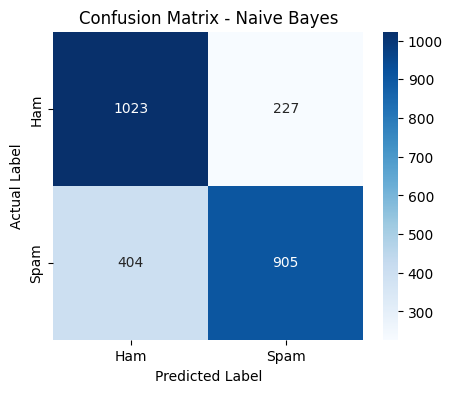

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [18]:
# Evaluate Logistic Regression
y_pred_lr = models["LogisticRegression"].predict(X_test)
report_lr = classification_report(y_test, y_pred_lr, target_names=["Ham", "Spam"])
print(f"📊 LogisticRegression Classification Report:\n", report_lr)


📊 LogisticRegression Classification Report:
               precision    recall  f1-score   support

         Ham       0.84      0.92      0.88      1250
        Spam       0.92      0.84      0.88      1309

    accuracy                           0.88      2559
   macro avg       0.88      0.88      0.88      2559
weighted avg       0.88      0.88      0.88      2559



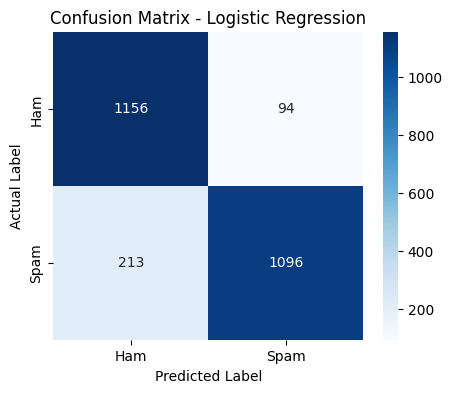

In [19]:
# Generate Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [20]:
# Evaluate SGD Classifier
y_pred_sgd = models["SGDClassifier"].predict(X_test)
report_sgd = classification_report(y_test, y_pred_sgd, target_names=["Ham", "Spam"])
print(f"📊 SGDClassifier Classification Report:\n", report_sgd)


📊 SGDClassifier Classification Report:
               precision    recall  f1-score   support

         Ham       0.87      0.96      0.91      1250
        Spam       0.95      0.86      0.91      1309

    accuracy                           0.91      2559
   macro avg       0.91      0.91      0.91      2559
weighted avg       0.91      0.91      0.91      2559



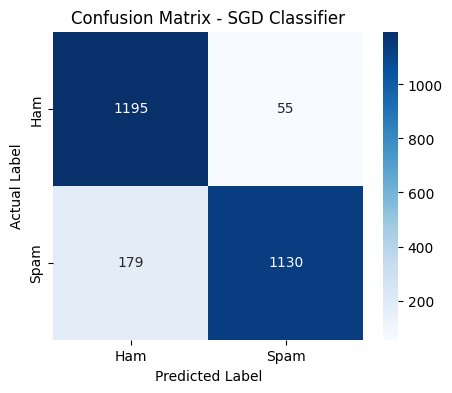

In [21]:
# Generate Confusion Matrix for SGD Classifier
cm_sgd = confusion_matrix(y_test, y_pred_sgd)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - SGD Classifier")
plt.show()


In [22]:
# Evaluate Random Forest
y_pred_rf = models["RandomForest"].predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, target_names=["Ham", "Spam"])
print(f"📊 RandomForest Classification Report:\n", report_rf)


📊 RandomForest Classification Report:
               precision    recall  f1-score   support

         Ham       0.90      0.94      0.92      1250
        Spam       0.94      0.91      0.92      1309

    accuracy                           0.92      2559
   macro avg       0.92      0.92      0.92      2559
weighted avg       0.92      0.92      0.92      2559



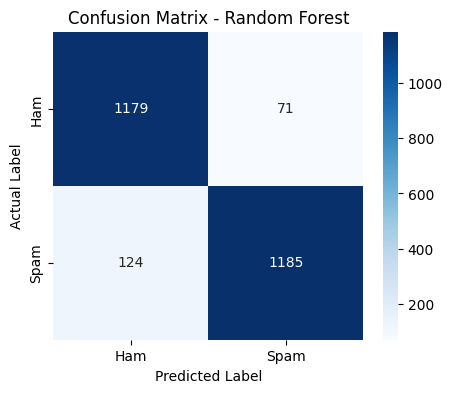

In [23]:
# Generate Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [24]:
# Evaluate Linear SVC
y_pred_svc = models["LinearSVC"].predict(X_test)
report_svc = classification_report(y_test, y_pred_svc, target_names=["Ham", "Spam"])
print(f"📊 LinearSVC Classification Report:\n", report_svc)


📊 LinearSVC Classification Report:
               precision    recall  f1-score   support

         Ham       0.89      0.96      0.92      1250
        Spam       0.95      0.89      0.92      1309

    accuracy                           0.92      2559
   macro avg       0.92      0.92      0.92      2559
weighted avg       0.93      0.92      0.92      2559



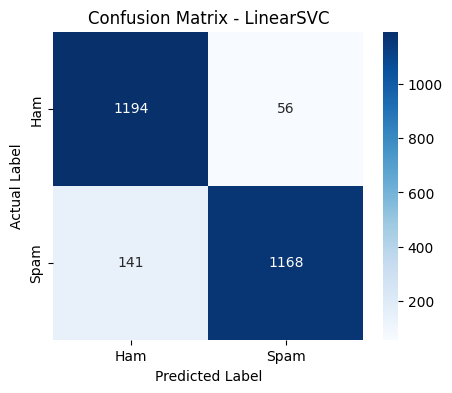

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - LinearSVC")
plt.show()


In [26]:
# Evaluate Stacking Classifier
y_pred_stack = stacking_clf.predict(X_test)
report_stack = classification_report(y_test, y_pred_stack, target_names=["Ham", "Spam"])
print(f"🚀 Stacking Classifier Classification Report:\n", report_stack)


🚀 Stacking Classifier Classification Report:
               precision    recall  f1-score   support

         Ham       0.93      0.96      0.94      1250
        Spam       0.96      0.93      0.94      1309

    accuracy                           0.94      2559
   macro avg       0.94      0.94      0.94      2559
weighted avg       0.94      0.94      0.94      2559



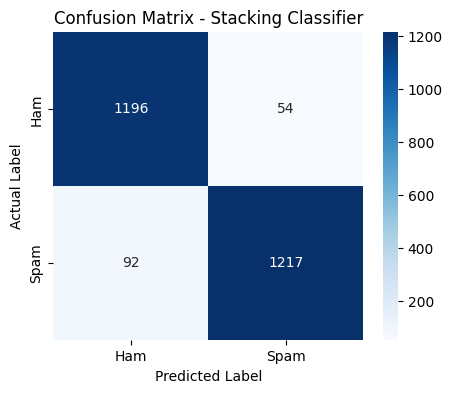

In [27]:
# Generate Confusion Matrix for Stacking Classifier
cm_stack = confusion_matrix(y_test, y_pred_stack)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Stacking Classifier")
plt.show()


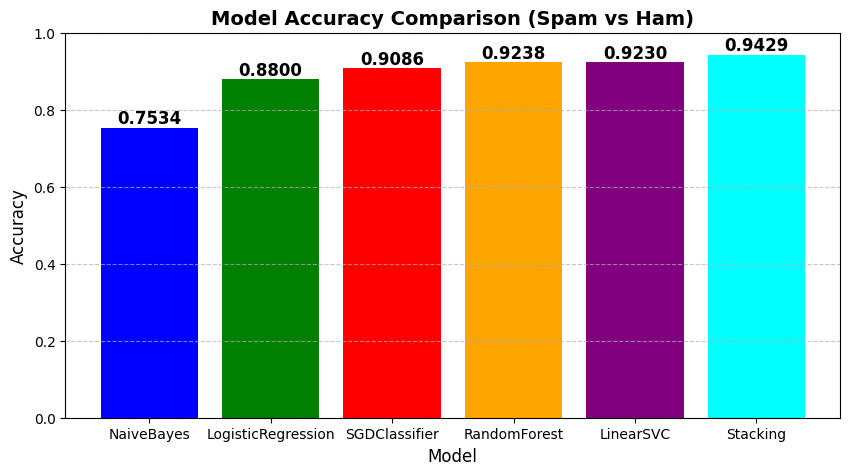

In [28]:
import matplotlib.pyplot as plt

# Plot model comparison
plt.figure(figsize=(10,5))
bars = plt.bar(model_scores.keys(), model_scores.values(), color=["blue", "green", "red", "orange", "purple", "cyan"])

# Add accuracy score labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize plot
plt.title("Model Accuracy Comparison (Spam vs Ham)", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [32]:
# Function to classify a custom email and check if it's from Enron
def classify_custom_email(email_text, sender_email):
    # Convert input text into numerical features using the same TF-IDF vectorizer
    email_features = vectorizer.transform([email_text])

    # Predict the label (Spam or Ham)
    predicted_label = label_encoder.inverse_transform(stacking_clf.predict(email_features))[0]

    # Check if sender is from Enron
    enron_status = "✅ Email is from an Enron employee." if sender_email.endswith("@enron.com") \
                   else "⚠️ ALERT: This email is NOT from an Enron employee."

    # Display result
    print("\n📩 **Custom Email Classification**")
    print(f"🔹 **Sender:** {sender_email}")
    print(f"🔹 **Input Text:** {email_text[:500]}...")  # Show first 500 characters
    print(f"🔹 **Predicted Label:** {predicted_label}")
    print(f"🔹 {enron_status}")

# New Sample emails for testing with diverse content
sample_emails = [
    {
        "sender": "alice.smith@enron.com",
        "text": "Reminder: The quarterly business strategy meeting is scheduled for Monday at 2 PM. Please review the agenda before attending."
    },
    {
        "sender": "support@fastcashdeals.com",
        "text": "Get a $1000 credit instantly! No credit check required. Apply now before this offer expires! Click here for details."
    },
    {
        "sender": "hr@enron.com",
        "text": "Please complete your annual employee benefits enrollment by Friday. Contact HR for assistance if you have any questions."
    },
    {
        "sender": "alerts@banksecure.com",
        "text": "Security Alert: We noticed an unusual login attempt on your account. Click the link below to verify your details immediately to avoid account suspension."
    },
    {
        "sender": "jack.brown@enron.com",
        "text": "Hey everyone, just a quick reminder that our department is hosting a lunch and learn event tomorrow at noon. See you all there!"
    },
    {
        "sender": "investment@profitnow.com",
        "text": "Exclusive investment opportunity! Get 200% returns on your money within 30 days. Join now and start earning big!"
    },
    {
        "sender": "laura.wilson@enron.com",
        "text": "Hey team, I need the latest project updates before our client presentation next week. Please send me your reports by Thursday."
    },
    {
        "sender": "promo@holidaydeals.com",
        "text": "Limited-time holiday sale! Get up to 70% off on all travel bookings. Hurry, offer ends soon! Book your dream vacation now."
    },
    {
        "sender": "security@paypal.com",
        "text": "Urgent: We have detected suspicious activity on your PayPal account. To keep your account safe, click the link below and update your credentials now."
    },
    {
        "sender": "john.miller@enron.com",
        "text": "Can someone help me with the financial report for Q3? I need to finalize the numbers before the end of the week."
    }
]

# Test classification on sample emails
for email in sample_emails:
    classify_custom_email(email["text"], email["sender"])
    print("\n" + "="*60 + "\n")  # Separator for readability



📩 **Custom Email Classification**
🔹 **Sender:** alice.smith@enron.com
🔹 **Input Text:** Reminder: The quarterly business strategy meeting is scheduled for Monday at 2 PM. Please review the agenda before attending....
🔹 **Predicted Label:** Ham
🔹 ✅ Email is from an Enron employee.



📩 **Custom Email Classification**
🔹 **Sender:** support@fastcashdeals.com
🔹 **Input Text:** Get a $1000 credit instantly! No credit check required. Apply now before this offer expires! Click here for details....
🔹 **Predicted Label:** Spam
🔹 ⚠️ ALERT: This email is NOT from an Enron employee.



📩 **Custom Email Classification**
🔹 **Sender:** hr@enron.com
🔹 **Input Text:** Please complete your annual employee benefits enrollment by Friday. Contact HR for assistance if you have any questions....
🔹 **Predicted Label:** Ham
🔹 ✅ Email is from an Enron employee.



📩 **Custom Email Classification**
🔹 **Sender:** alerts@banksecure.com
🔹 **Input Text:** Security Alert: We noticed an unusual login attempt on your 

In [31]:
import joblib
import os

# Define the directory to save models
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save the trained TF-IDF Vectorizer
vectorizer_path = os.path.join(save_dir, "tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)

# Save the trained Stacking Classifier model
model_path = os.path.join(save_dir, "stacking_classifier.pkl")
joblib.dump(stacking_clf, model_path)

# Save the Label Encoder
label_encoder_path = os.path.join(save_dir, "label_encoder.pkl")
joblib.dump(label_encoder, label_encoder_path)

# Save the dataset with predictions
dataset_path = os.path.join(save_dir, "classified_emails.csv")
df.to_csv(dataset_path, index=False)

# Confirm saved files
print("Saved Files for Website Integration:")
print(f" TF-IDF Vectorizer: {vectorizer_path}")
print(f" Stacking Classifier Model: {model_path}")
print(f" Label Encoder: {label_encoder_path}")
print(f" Classified Dataset: {dataset_path}")


Saved Files for Website Integration:
 TF-IDF Vectorizer: saved_models/tfidf_vectorizer.pkl
 Stacking Classifier Model: saved_models/stacking_classifier.pkl
 Label Encoder: saved_models/label_encoder.pkl
 Classified Dataset: saved_models/classified_emails.csv
